# Urban cycling - Predicting bike rentals

## Motivation

In light of the current climate crisis, bicycles are gaining in importance as a low- emission means of transportation. Increased use of bicycles can also improve air quality in large cities, as well as help relieve traffic congestion. Compared to the conventional use of bicycles, bike sharing systems offer the advantage of data collection regarding travel time, departure and arrival locations. This data can be used to predict how many people will rent a bike on a certain day or at a certain time of day. These insights may be valuable for a stronger integration of bicycles into traffic.

## Dataset

The dataset for this project comes from the "Capital Bikeshare" program, which is based in Washington, D.C.. Over a two-year period (2011 - 2012), the dataset contains the number of daily as well as hourly bike rentals. These are further broken down into rentals by registered and casual users. In addition, the dataset provides a variety of attributes, both in terms of weather data, and in terms of various calendar information, such as season, vacation, month. In total, the dataset contains 17389 rows and 16 columns.
Source: https://archive.ics.uci.edu/ml/machine-learning-databases/00275/

## Research Questions

How well can the daily use of bicycles in cities be predicted?  
● Can the number of daily bicycle rentals in Washington be predicted using weather data and calendar information?  
● Which of these features are most important for predicting bikerentals in Washington D.C.?  
● How are casual users different from registered users (This notebook addresses only registered users)?  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from math import sqrt

In [2]:
df = pd.read_csv('./Bike-Sharing-Dataset/day.csv', sep=',')

In [3]:
# Features were already transformed (in some way) in the dataset. Here I recover the original data and then normalize
# them using Stadard Scaler

df['temp_org'] = df['temp']*(39-(-8)) + (-8)
df['atemp_org'] = df['atemp']*(50-(-16)) + (-16)
df['windspeed_org'] = df['windspeed']*100
df['hum_org'] = df['hum']*67

data_num = df[['atemp_org', 'temp_org', 'hum_org', 'windspeed_org']].copy()

X_num = StandardScaler().fit_transform(data_num)

# Normalized data is added to the dataframe

df['atemp_norm'] = X_num[:,0]
df['temp_norm'] = X_num[:,1]
df['hum_norm'] = X_num[:,2]
df['windspeed_norm'] = X_num[:,3]

## Dealing with correlation among feature variables:

# Multicollinearity

Bloomberg: https://bloomberg.github.io/foml/#lectures   
When performing linear regression we obtain the normal equations $A^TAx = A^Ty$ where
$A \in R^{m×n}$, $x \in R^n$, and $y \in R$.
If rank(A) = n then solve the normal equations for x.
What if rank(A) $\neq n$ (perfect mulitcollinearity)?
Then the equation always has infinitely many solutions x. First note
that rank(A) $\neq n$ implies rank(A) $< n$ since you cannot have larger rank than
the number of columns. Next, recall $rank(A) = rank(A^T A)$. Hence, by rank-
nullity, $A^TA$ has a non-trivial nullspace, which in turn implies that if there is a
solution, there must be infinitely many solutions. Thus we cannot compute the inverse of $A^TA$

Wikipedia :https://en.wikipedia.org/wiki/Multicollinearity  
In practice, perfect multicollinearity in a data set is rare. More commonly, the issue of multicollinearity arises when there is an approximate linear relationship among two or more independent variables. For variables that are nearly perfectly multicollinear a given computer algorithm may or may not be able to compute an approximate inverse, and if it does so the resulting computed inverse may be highly sensitive to slight variations in the data (due to magnified effects of either rounding error or slight variations in the sampled data points) and so may be very inaccurate or very sample-dependent. Thus $w = (A^TA)^{−1}X^Ty$, the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.   

## Empirical Risk of Square Loss  (https://bloomberg.github.io/foml/#lectures)

Denote the empirical risk of $f(x) = w^Tx$ by  
$\hat{R}_n(w) = \frac{1}{n} ||Xw - y||^2$   where X is the design matrix.  
$\hat{R}_n$ is minimized by $\hat{w} = (X^TX)^{-1} X^Ty$, the OLS solution.  
What does $\hat{R}_n$ look like around $\hat{w}$ ?  
By "completing the square", we can show for any $w \in R^d$:  
  
$\hat{R}_n(w) = \frac{1}{n} (w - \hat{w})^TX^TX(w - \hat{w}) + \hat{R}_n(\hat{w})$  

Set of w with $\hat{R}_n(w)$ exceeding $\hat{R}_n(\hat{w})$ by $c >0$ is  

$\{w | \hat{R}_n(w) = c + \hat{R}_n(\hat{w})\} = \{w | (w - \hat{w})^TX^TX(w - \hat{w}) = nc\}$    

which is an ellipsoid centered at $\hat{w}$ ($\hat{\beta}$ in the picture below).  

Hastie et al.:  

![Hastie et al.](ell.png)


Blue region: Area satisfying complexity constraint: left: $|w_1| + |w_2| <= r$, right: $w_1^2 + w_2^2 <= r$


## Linear dependent features

Suppose we have only one feature $x_1$ and the ERM is $\hat{f}(x_1) = 4x_1$. 

What happens if we get a new feature $x_2 = x_1$  ?  

Now we have an infinite amount of possible ERMs with $w_1 + w_2 = 4$, e.g.:  

$\hat{f}(x_1, x_2) = 4x_1$  
$\hat{f}(x_1, x_2) = 2x_1 + 2x_2$  
$\hat{f}(x_1, x_2) = 4x_2$  

This is the case of perfect multicollinearity.  

What if we introduce $l_1$ or $l_2$ regularization?  

$\hat{f}(x_1, x_2) = w_1x_1 + w_2x_2$ is an ERM iff $w_1 + w_2 = 4$.  

Consider the $l_1$ and $l_2$ norm of various solutions:  


|$w_1$  | $w_2$  | $l_1$       | $l_2$        |
|:-----:|:------:|:-----------:|:------------:|
| 4     | 0      | 4           | 16           |
| 2     | 2      | 4           | 8            |
| 1     | 3      | 4           | 10           |
| -1    | 5      | 6           | 26           |


$||w||_1$ doesnt discriminate, as long as all have the same sign  
$||w||_2^2$ minimized when weight is spread equally  

Geometric view: In the picture above for linearly dependent features we get a degenerate ellipse with an infinite major axis $(X^TX$ is going to have at least one eigenvalue = 0). For the $l_2$ norm a parallel line hits the norm-ball at a point, where $w_1$ = $w_2$. 

### Linearly related features

Same setup, now suppose $x_2 = 2x_1$. 
Then all functions with $w_1 + 2w_2 = k$ are the same.  
For $l_1$ or $l_2$ regularization you want to put more weight on the feature that is the larger scaled version, because the parameter you need is smaller.
For the $l_2$ constraint we hit tne norm-ball at $w_2 = 2w_1$.
For the $l_a$ constraint we hit tne norm-ball at a corner, with $w_1 = 0$.

## Summary:  
Identical features:  
$l_1$ regularization spreads weight arbitrarily  (all weights same sign)  
$l_2$ regularization spreads weight evenly

Linearly related features:  
$l_1$ regularization chooses variable with larger scale, 0 weight to others  
$l_2$ regularization prefers variables with larger scale, spreads weight proportional to scale

Note: In practice you rescale your features to have the same magnitude

## Correlated features

Suppose $x_1$ and $x_2$ are highly correlated and have the same scale (leads to strechted out ellipses)  
This is typicla scenario after normalizing your data  
The higher the correlation, the closer we come to degenerate ellipsoids

For $l_1$ regularization  minor perturbations in data can then drastically change intersection point with the norm-diamond.   
This makes division of weight among highly correlated features (of same scale) seem arbitrary.  
    If $x_1 \approx 2x_2$, ellipse changes orientation and we probably hit a corner.

### Highly correlated features were not included into the dataset together
#### E.g.: Person Corr. of Temperature and perceived temperature: 0.99

One of the research question is about identifying important features for predicting bike rentals. Although highly correlated features might not worsen the predicitve ability of the model they make the  coefficient estimates unstable and the individual contribution of predictors can't be interpreted. Especially for the $l_1$ regularization slight changes in the data can lead to drastically changing coefficients.

In [4]:
# Selecting features

numercial_features = ['atemp_norm', 'hum_norm', 'windspeed_norm', 'holiday',
       'workingday']

categorical_features = ['season','weathersit']

X = df[numercial_features]

# One-Hot Encoding for categorical variables

from sklearn.preprocessing import OneHotEncoder

categorical_data = df[categorical_features]

# 1. INSTANTIATE
enc = OneHotEncoder()

# 2. FIT
enc.fit(categorical_data)

# 3. Transform
onehotlabels = enc.transform(categorical_data).toarray()

cat_onehot_df = pd.DataFrame(onehotlabels, columns = ['season1', 'season2', 'season3', 'season4', 'weathersit1', 'weathersit2', 'weathersit3'])

X = pd.concat([X,cat_onehot_df], axis = 1, join = 'inner')
X

,atemp_norm,hum_norm,windspeed_norm,holiday,workingday,season1,season2,season3,season4,weathersit1,weathersit2,weathersit3
0,-0.679946,1.250171,-0.387892,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.740652,0.479113,0.749602,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.749767,-1.339274,0.746632,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.610270,-0.263182,-0.389829,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.504971,-1.341494,-0.046307,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.521108,0.175807,2.061426,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
727,-1.346690,-0.266238,-0.452131,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
728,-1.424344,0.878392,-0.853552,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
729,-1.490049,-1.015664,2.069444,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# The responsse variable is the number of bike rentals for registered users
y = df['registered']

# Doing a train test split of the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
# Now I want to fit a regularized regression model (l2 norm) to the training dataset

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

# the "best" value for the regularaization parameter alpha is obtained using Cross-Validation

model_rigde = RidgeCV(alphas=np.logspace(-10, 10, 21), fit_intercept=True)
        
model_rigde.fit(X_train, y_train)

model_rigde.alpha_



1.0

Then we check the performance of the computed model plotting its predictions
on the test set and computing,
for example, the mean squared error of the model.



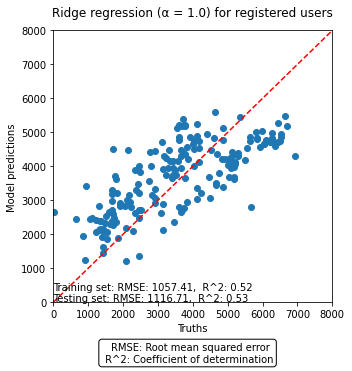

In [7]:
y_pred = model_rigde.predict(X_train)

mae = sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred))
c_det = r2_score(y_train, y_pred)
string_score = f"Training set: RMSE: {mae:.2f}" + ", " + " R^2: "  + "{:.2f}".format(c_det)
y_pred = model_rigde.predict(X_test)
mae = sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))
c_det = r2_score(y_test, y_pred)
string_score += f"\nTesting set: RMSE: {mae:.2f}" + ", " + " R^2: "  + "{:.2f}".format(c_det) 
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
ax.annotate('RMSE: Root mean squared error \n R^2: Coefficient of determination', xy=(220, -40), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
plt.text(3, 20, string_score)
plt.title("Ridge regression (\u03B1 = 1.0) for registered users", x=0.5, y=1.03)
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 8000])
_ = plt.ylim([0, 8000])
plt.savefig('  Number of registered bike rentals ', dpi = 500, bbox_inches='tight')

Although the datapoints are somewhat uniformly distributed around the diagonal, the coefficient of determination is rater low, both for training and test data. As the performance of the model is slightly better on the test data set, the model complexity is probably rather on the low side. Here might be room for improvement. Low $R^2$ values also questions interpreting the models coefficients, as they might change for model that has greater predictive power. Nevertheless I want to proceed trying to interpret feature importance for this particular model.

## Interpreting coefficients

First of all, we can take a look to the values of the coefficients of the
regressor we have fitted.

In [9]:
feature_names = X.columns

coefs = pd.DataFrame(
    model_rigde.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
atemp_norm,768.057721
hum_norm,-246.869372
windspeed_norm,-128.234429
holiday,-171.295155
workingday,922.525027
season1,-542.315422
season2,23.329909
season3,-229.796058
season4,748.781571
weathersit1,487.979402


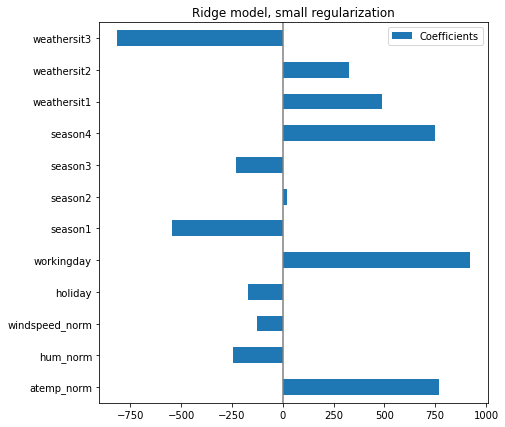

In [10]:
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### Example: Holiday feature

In [11]:
training_set = X_train.copy()
training_set["registered"] = y_train


          registered  holiday
holiday                      
0        3715.672285      0.0
1        2769.857143      1.0


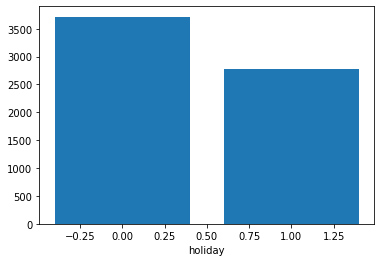

In [12]:
mean_data = training_set[["registered", "holiday"]].groupby(X_train["holiday"]).mean()
print(mean_data)

plt.bar(mean_data.index, mean_data['registered'])
plt.xlabel("holiday")
plt.show()

For the feature "holiday" we have a negative coefficient of about -180. Thus moving from 0 (no holiday) to 1 on the holiday variable the number of registered bike rentals decreases. The coefficient value signifies how much the mean of the dependent variable changes given a one-unit shift in the independent variable while holding other variables in the model constant. My intuition is that to obtain the value of coefficients we are calculating partial derivatives of the objective function, treating other varibales as constant.
For the "holiday" feature there are on average about 180 less bike rentals on an holiday compared to a regular day. This difference is not reflected in the plot above, as other variables in the model are not hold constant for this mean calculation. Also we are using regularized regression, where coefficients are getting smaller, dependeing on the regularization parameter. A larger regularization parameter is reducing the model complexity, which reduces the variance of the model.

## Note: Bias variance dilemma

It is assumed that there is a functional but noisy relation between $x_i$ and $y_i$ described by $y_i = f (x_i) + \epsilon$ with variance of $\epsilon$ eaual to $\sigma^2$. Now, using a learning algorithm, find a function $\hat{f}(x)$ that approximates the true function $y = f(x)$ as closely as possible.

It turns out that depending on the choice of the function $\hat{f}(x)$ the expected deviation with respect to an unseen sample x can be decomposed as follows.  

$E[(y - \hat{f}(x))^2] = Bias[\hat{f}(x)]^2 + Var[\hat{f}(x)] + \sigma^2$

However, we cant simultaneously reduce Bias and variance of the model. The more complex the model function $\hat{f}(x)$ is, the more data points it will capture correctly and the lower its bias will be. However, higher complexity makes the model function fluctuate more to better capture the data points, which thus increases its variance. 
With a larger regularization and a lower model complexity, the bias of the model increases, caused by simplifying assumptions within the procedure. For example, if a nonlinear function $f(x)$ is approximated using a learning procedure for linear models, there will be errors in the estimates $\hat{f}(x)$ due to such an assumption.

## Feature importance

Interpreting the importance of features is not trivial. In the current analysis we have standardized features that have low pairwise correlations. However we could still have an approximate linear relationship among more than two variables. 
Therefore I will also check for multi-collinearity by using Variance Inflation Factor(VIF) for each independent variable. The VIF for feature i is defined as $\frac{1}{1-R^2_i}$, where $R^2_i$ is the coefficient of determination from running a regression of all the other features and a constant term on feature i.

In OLS regression, if we use ont-hot encoding we usually leave out one level to avoid the issue of multicollinearity. According to this statement: https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding for regularized regression the regularization takes care of the singularities, and more important, the prediction obtained may depend on which columns you leave out. Thus I did not leave out any of the one-hot encoded variables. Although we do not have a problem with singularities we still have a perfect linear relation between one of the one-hot encoded variables and the remaining ones (plus constant term). This is also reflected in VIF coefficients below.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_vif = X_train.copy()
df_vif = add_constant(df_vif)

vif = pd.DataFrame()
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,vif_Factor
0,const,0.000000
1,atemp_norm,3.401864
2,hum_norm,1.833202
3,windspeed_norm,1.181268
4,holiday,1.057614
5,workingday,1.066883
6,season1,inf
7,season2,inf
8,season3,inf
9,season4,inf


Apart form the one-hot ecoded variables we have rather low VIF values (all below 5), indicating no linear relationship between one of these variables and the remaining predictors. Thus we can interpret the size for these coefficients as their importance for predicting the number of bike rentals. Note however that the coefficients also change depending on the particular model. Thus the magnitude of a coefficient is related to the importance of the respective feature in a particular model, but not to its intrinsic predictive ability.

Feature importance for VIF < 5:  

The feature "workingday" has the largest coefficient, suggesting the largest influence on the number of bike rentals in our speficic model. One interpretation might be, that registered users use rent their bikes for daily tasks rather then for leisure activities on  weekends. The second largest coefficient belongs to the perceived temperature. This seems reasonable, as one probabaly prefers to ride a bike at warm temperatures. Humidity has the third largest coefficient, whereas people tend to rent less bikes, when the humidity is high. For all three coefficients their big influence on bike rentals is not surprising. 

## Stability of coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
`resampling <https://en.wikipedia.org/wiki/Resampling_(statistics)>`_).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

In [16]:
coeff = model_rigde.coef_
coeff = np.reshape(coeff, (1,12))
coefs = pd.DataFrame(
    coeff,
    columns=feature_names
)

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model_rigde,
    X_train,
    y_train,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)


coefs = pd.DataFrame([est.coef_ for est in cv_model["estimator"]],
   columns=feature_names,)


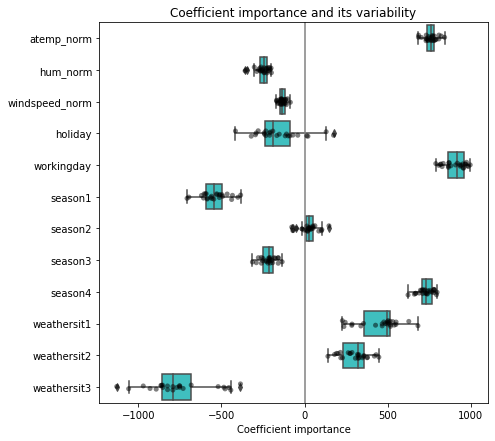

In [18]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

Now we check the variability of the three most important coefficients as described above   (workingday, atemp, hum). The coefficient values don't change much over our CV loop for all three features, thus increasing our confidence in their importance for predicting bike rentals. In contrast the coefficients for the feature "holiday" vary a lot, including some that are close to zero. 

## Permutation feature importance  
https://scikit-learn.org/stable/modules/permutation_importance.html

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled [1]. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.  
Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

In [21]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model_rigde, X_train, y_train,
                        n_repeats=30,
                         random_state=0)



In [25]:
r.importances_mean

array([4.94106390e-01, 5.08174030e-02, 1.32516964e-02, 3.48017781e-04,
       1.63643354e-01, 4.60574883e-02, 4.34616741e-05, 8.61177659e-03,
       9.03607102e-02, 4.82404590e-02, 2.06812715e-02, 1.92703738e-02])

In [29]:
feature_names = X.columns

feature_importance = pd.DataFrame(
    r.importances_mean,
    columns=["Importance"],
    index=feature_names,
)
feature_importance.sort_values("Importance", axis = 0, ascending = False)

,Importance
atemp_norm,0.494106
workingday,0.163643
season4,0.090361
hum_norm,0.050817
weathersit1,0.048240
season1,0.046057
weathersit2,0.020681
weathersit3,0.019270
windspeed_norm,0.013252
season3,0.008612


Interestingly, also for this model inspection technique the features atemp, workingday and hum are among the most important predictors. The feature season4 (autumn) is in third place. However, as mentioned earlier, there is strong multicollinearity due to one-hot coding, so the coefficients must be interpreted with caution. 